This file produces the result in Secion Result in the report, where we analyze the plots in detail.

## Load Packages

In [42]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import load_data, data_augmentation, get_labels, load_history
from visualization import show_sample, plot_loss, show_prediction
from models import init_model_1, init_model_2, training, save_model, predict

In [43]:
data_path = './data'
checkpoint_filepath = './modelcheckpoints'
model_path = './model'

## Evaluation
 

### Model 1

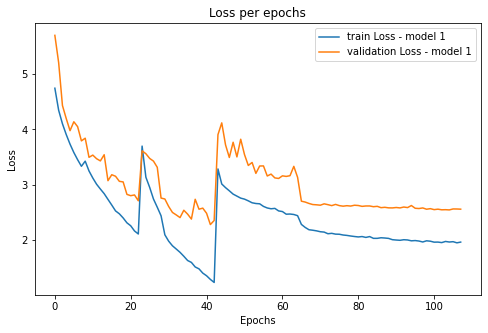

In [56]:
# get log file list
history_ls_model_1 = [filename for filename in os.listdir(checkpoint_filepath) if 
                    filename.endswith(".log") and filename.startswith("model1")]
history_ls_model_1.sort()

# load log files of two models
history_model_1 = load_history(checkpoint_filepath, history_ls_model_1)

# plot loss
plot_loss(history_model_1, 'model 1')

### Model 2

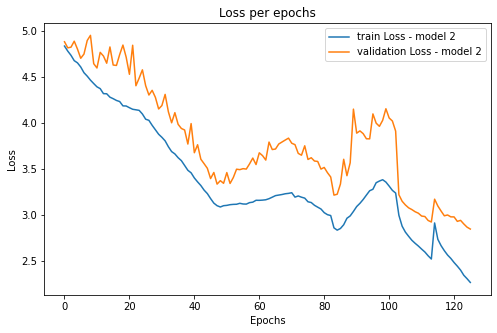

In [57]:
# get log file list
history_ls_model_2 = [filename for filename in os.listdir(checkpoint_filepath) if 
                    filename.endswith(".log") and filename.startswith("model2")]
history_ls_model_2.sort()

# load log files of two models
history_model_2 = load_history(checkpoint_filepath, history_ls_model_2)

# plot loss
plot_loss(history_model_2, 'model 2')

## Prediction

### Load validation data

In [3]:
# get validation data generator
_, _, test_generator = load_data(data_path, img_width=64, img_height=64, 
                                 batch_size=128, augmentation=None, seed=None, load_test=True)

Begin loading...
Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.
Training data shape: (80000, 64, 64, 3)
Validation data shape: (20000, 64, 64, 3)
Found 10000 validated image filenames belonging to 200 classes.
Testing data shape: (10000, 64, 64, 3)
End loading!


### Model 1

In [59]:
# load best model
# for gcp model (model 1)
best_model_1 = tf.keras.models.load_model(model_path+'/model1.h5') 

Start evaluating...
79/79 [==============================] - 60s 765ms/step - loss: 1.8482 - accuracy: 0.5535
Loss:1.85
Accuracy:0.55
Start predicting...will take a few minutes


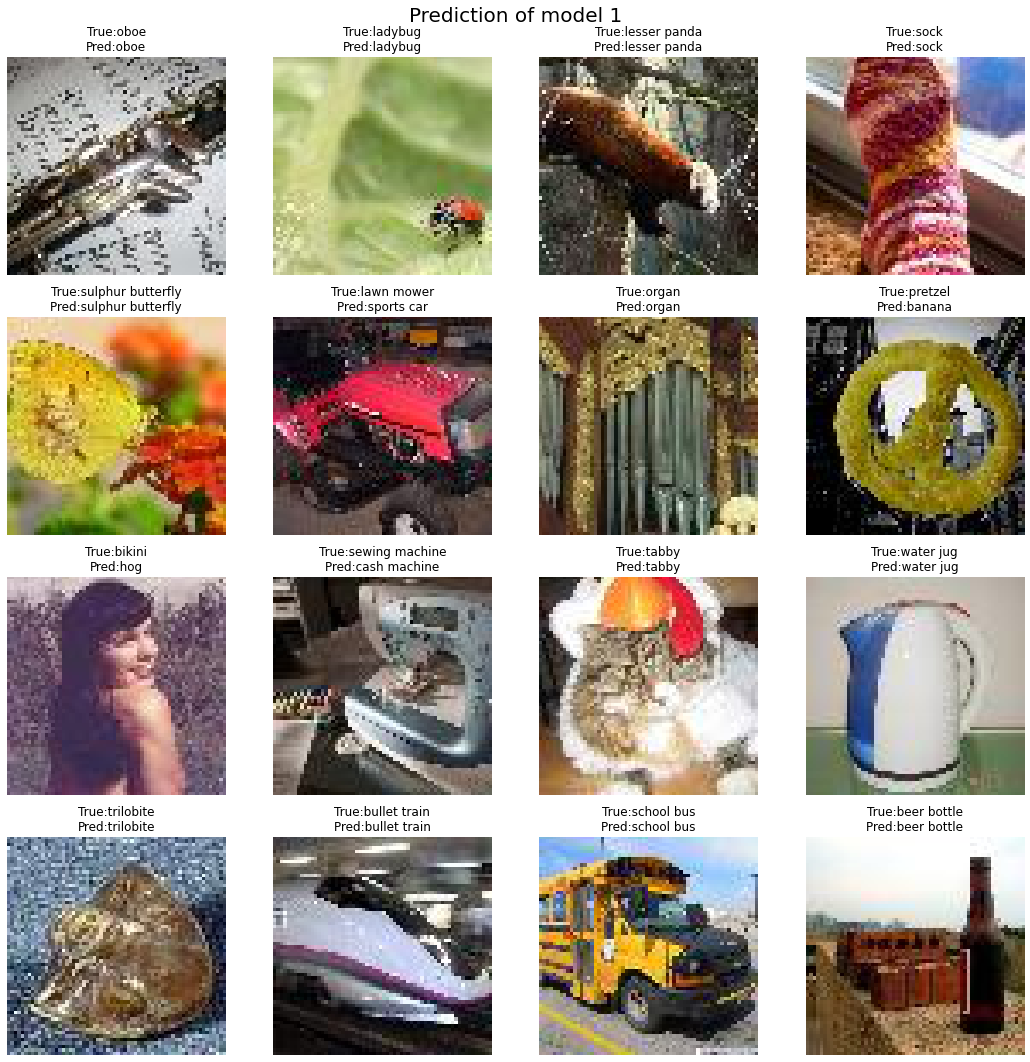

In [60]:
scores_model_1, true_labels_model_1, predict_labels_model_1 = predict(best_model_1, test_generator, 'model 1', data_path)

In [61]:
prediction = pd.DataFrame({'class':true_labels_model_1, 'pre':predict_labels_model_1})
prediction['result'] = prediction['class'] == prediction['pre']
prediction = prediction.groupby('class').agg({'result':'mean'}).reset_index()
prediction = prediction.sort_values('result')
prediction.head()

,class,result
178,syringe,0.100000
138,plunger,0.145833
199,wooden spoon,0.163265
191,umbrella,0.220000
48,bucket,0.230769


### Model 2

The reason why model 2 performs bad in prediction might be becuase model 2 is trained using augmented data, but tested on the original data. This indicating that the our data augmention methods does not help much in learning the dataset. Given more time and computation resources, we would like to try other data augmentation methods.

In [50]:
# load best model
# for colab model (model 2)
best_model_2 = init_model_2((None, None, 3))
best_model_2.load_weights(model_path+'/model2.h5')  

opt2 = Adam(lr=1e-4, epsilon=1e-08)
best_model_2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])

Start evaluating...
79/79 [==============================] - 31s 388ms/step - loss: 6.6642 - accuracy: 0.0585
Loss:6.66
Accuracy:0.06
Start predicting...will take a few minutes


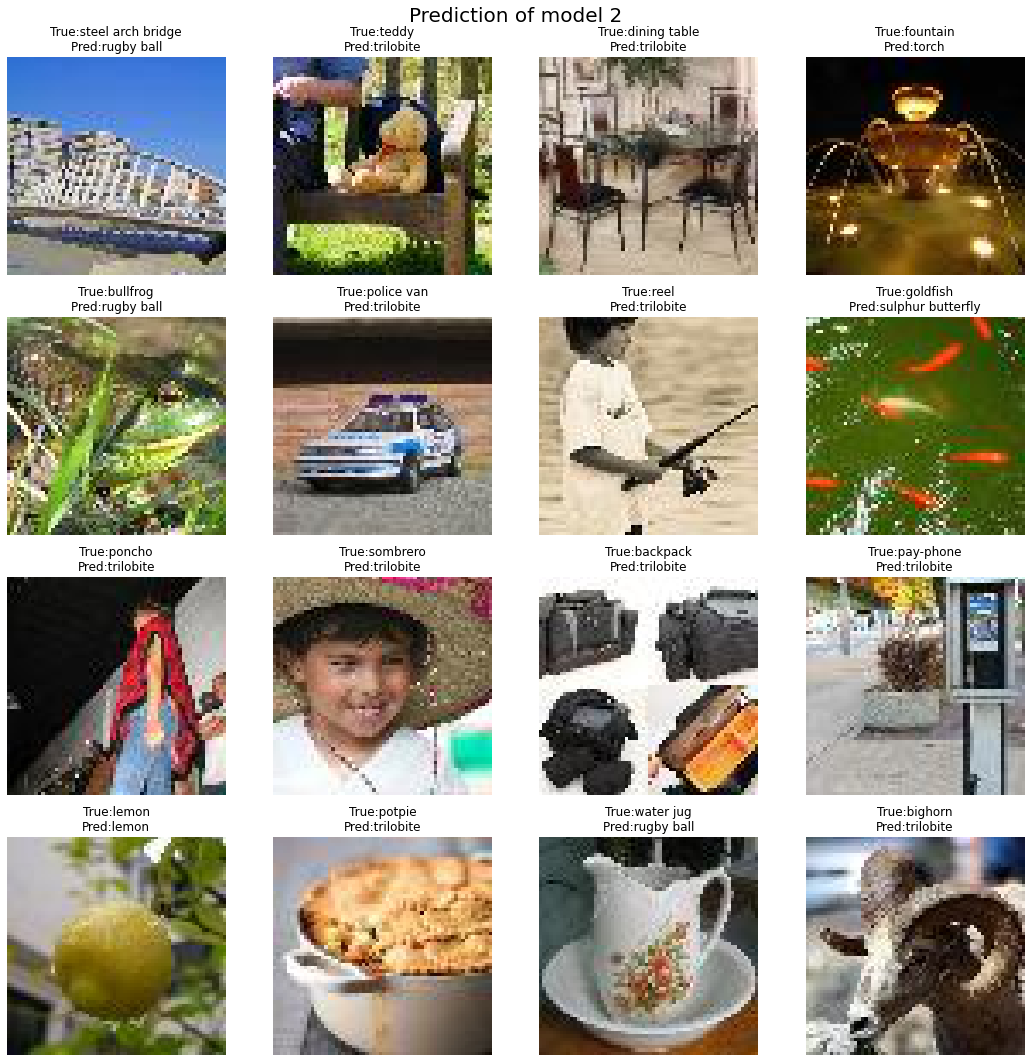

In [51]:
scores_model_2, true_labels_model_2, predict_labels_model_2 = predict(best_model_2, test_generator, 'model 2', data_path)

In [52]:
prediction_model_2 = pd.DataFrame({'class':true_labels_model_2, 'pre':predict_labels_model_2})
prediction_model_2['result'] = prediction_model_2['class'] == prediction_model_2['pre']
prediction_model_2 = prediction_model_2.groupby('class').agg({'result':'mean'}).reset_index()
prediction_model_2 = prediction_model_2.sort_values('result')
prediction_model_2.head()

,class,result
0,African elephant,0.0
119,military uniform,0.0
120,miniskirt,0.0
122,moving van,0.0
123,mushroom,0.0


## Visualize data and augmented data

In [26]:
data_aug_args = dict(CoarseDropout_range=(0.0, 0.05),
                     CoarseDropout_size_percent=(0.02, 0.25),
                     Affine_translate_percent=(-0.2, 0.2),
                     Affine_scale=(0.5, 1.5),
                     Affine_shear=(-20, 20),
                     Affine_rotate=(-45, 45),
                     Flip_percent=0.5,
                     GaussianBlur_sigma=(0.0, 3.0),
                     CropAndPad_percent=(-0.25, 0.25),
                     Multiply=(0.5, 1.5),
                     LinearContrast=(0.4, 1.6),
                     AdditiveGaussianNoise_scale=0.2*255)

aug = data_augmentation(complicated=False, **data_aug_args)

# get original data generator
train_generator_sample, val_generator_sample = load_data(data_path, img_width=64, img_height=64, 
                                                   batch_size=128, augmentation=None, 
                                                   seed=123)


# get augmented data generator
train_generator_aug_sample, val_generator_aug_sample = load_data(data_path, img_width=64, img_height=64, 
                                                   batch_size=128, augmentation=aug, 
                                                   seed=123)

Begin loading...
Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.
Training data shape: (80000, 64, 64, 3)
Validation data shape: (20000, 64, 64, 3)
End loading!
Begin loading...
Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.
Training data shape: (80000, 64, 64, 3)
Validation data shape: (20000, 64, 64, 3)
End loading!


In [27]:
# get samples from generators
sample_img_ori, sample_index_ori = train_generator_sample.next()
sample_img_aug, sample_index_aug = train_generator_aug_sample.next()
# get labels of images
sample_label = get_labels(data_path, sample_index_ori, train_generator_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


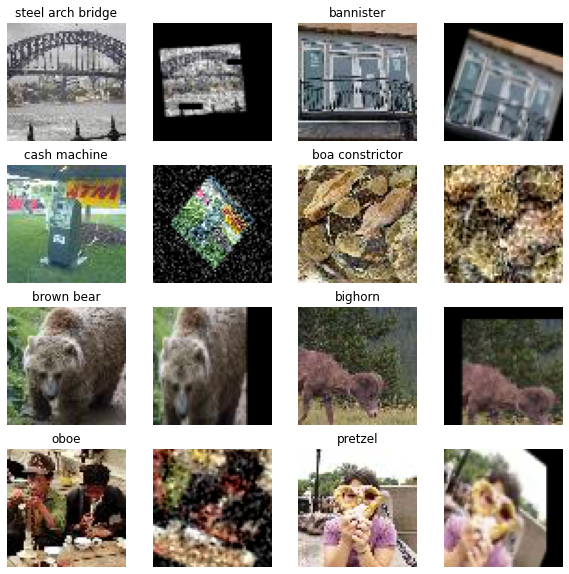

In [28]:
# call function to plot
show_sample(sample_img_ori, sample_img_aug, labels=sample_label)